# Analysing "How ISIS Uses Twitter" using social network cluster analysis
## Approach
The general approach will be to extract each unique user by their username to act as a node. The username has been chosen as the associated data on each node as it is unique unlike names which might not be. The scale of the node will be influenced by the a combination of the number of followers and the number of tweets they produce. This combination will ensure that active and popular users are identified rather than identifying those who tweet a lot and have a small amount of followers or vice versa.

Currently the relation between each user is yet to be decided, as well as the number of followers, who those followers are would be useful to identify the relation between different users. One relation criteria might be to scrape the tweets of users for mentions and then link nodes via this metric with numerous mentions increasing the weight of an edge between two users. In this context two types of mentions could be identified, those that result in direct communication with a user and those mentions that come from retweeting a user. The former could be combined with language processing to determine the emotive qualities of the tweets to see if there are inner hostilities between ISIS supporters.

## First Steps
Matplotlib, as always, will be used to provide visualizations of statistics gathered from the data. NetworkX is a useful graph library which allows for the visualization of graphs, its draw functions are directly linked to matplotlib allowing for similar looking visualizations to be created.

In [98]:
%matplotlib inline
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import re
import numpy as np
from collections import Counter

dataset = pd.read_csv("data/tweets.csv")

The first interesting stat to find would be how many users in the dataset tweet each other? The first two print commands are to check that there are no duplicate tweets which would skew results. The only disadvantage is that this relies on an exact string match, if retweets have been preceeded by an RT then this would not pick up duplicates.

Using a regex expression we can catch those tweets that contain "RT" at the start of the tweet (indicating a retweet) and count them. Compared to the previous check we can see roughly 6000 tweets are not actually useful due to them being retweets. Despite this they are useful for future reference in testing what relation criteria to use.

Unique tweets: 17410
All tweets: 17410


[<matplotlib.text.Text at 0x11ad28d68>, <matplotlib.text.Text at 0x11c281f28>]

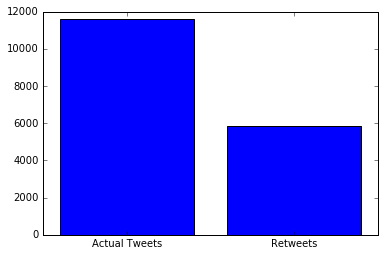

In [99]:
print("Unique tweets: {}".format(len(dataset['tweets'].unique())))
print("All tweets: {}".format(len(dataset['tweets'])))

retweets = []
actual_tweets = []
for user, tweet in zip(dataset['username'], dataset['tweets']):
    match = re.search(r'^\bRT\b', tweet)
    if match == None:
        actual_tweets.append([user,tweet])
    else:
        retweets.append([user,tweet])   

actual_tweets = np.array(actual_tweets)
retweets = np.array(retweets)

plt.bar([1,2], [len(actual_tweets[:,1]), len(retweets[:,1])], align='center')
ax = plt.gca()
ax.set_xticks([1,2])
ax.set_xticklabels(['Actual Tweets', 'Retweets'])

## Who talks about who?
Now we have seperated the retweets and actual tweets and grouped them with their usernames we can proceed to perform some analysis on who is talking about who! Firstly we iterate through each tweet and scrape mentioned usernames from them. These usernames are then determined to either be users from within tweets.csv or not within tweets.csv. It is clear to see from the below bar chart that the majority of users mentioned are outside the scope of the dataset. This opens up another avenue for producing the social graph where a graph of all users mentioned can be constructed with colour defining those that are known (within the dataset) and those that aren't known (not within the dataset). For now we'll focus on those contained only within the dataset as this is a smaller set of users to work with.

[<matplotlib.text.Text at 0x11c1ebe48>, <matplotlib.text.Text at 0x117ace4e0>]

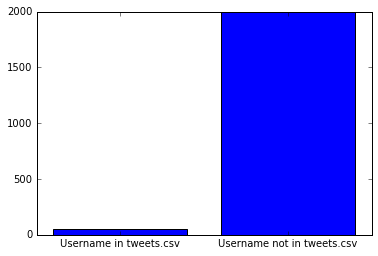

In [100]:
in_set = []
not_in_set = []
for record in actual_tweets:
    match = re.findall(r'@\w*', record[1])
    if match != []:
        for name in match:
            if name[1:] in dataset['username'].unique():
                in_set.append([record[0], name])
            else:
                not_in_set.append([record[0], name])

in_set = np.array(in_set)
not_in_set = np.array(not_in_set)

plt.bar([1,2], [len(set(in_set[:,1])), len(set(not_in_set[:,1]))], align='center')
ax = plt.gca()
ax.set_xticks([1,2])
ax.set_xticklabels(['Username in tweets.csv', 'Username not in tweets.csv'])

To map out the most influential (most tweeted) users we need to count how many times they are mentioned. This is done via counting the in_set list, as can be seen below the most tweeted user currently (and by a large amount) is WarReporter1.

In [101]:
user_count = Counter(in_set[:,1])
print(user_count.most_common(5))

[('@WarReporter1', 131), ('@RamiAlLolah', 53), ('@Uncle_SamCoco', 48), ('@Nidalgazaui', 34), ('@ismailmahsud', 30)]


What is WarReporter1 all about? Looks like WarReporter1 is a feed reporting on conflicts but claims to be impartial, wonder why it was included in this set?

In [102]:
dataset[dataset['username'] == 'WarReporter1']['description'].unique()

array([nan, 'Reporting on conflicts in the MENA and Asia regions.',
       'Reporting on conflicts in the MENA and Asia regions. Not affiliated to any group or movement.'], dtype=object)

After going on a tangent and looking at WarReporter1 let's map these "most tweeted" to a graph! (albeit no edges yet). For the time being these nodes will remain in a circle, the usernames haven't been added as labels yet as it looks hecka messy.

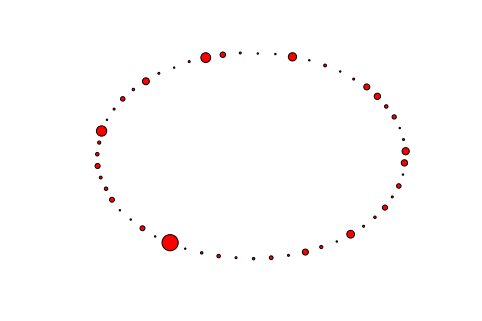

In [103]:
graph = nx.Graph()
graph.add_nodes_from(user_count.keys())
nx.draw(graph, node_size = [size*2 for key, size in user_count.items()])
plt.show()